In [241]:
# Import utilities for loading and plotting data
from neurodsp.spectral import compute_spectrum
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fooof import FOOOFGroup
from scipy.stats import mode
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

In [2]:
# Load the CSV file into a DataFrame and enter some details about the subject
eeg_data = pd.read_csv(input("Enter location of csv file which includes EEG signal for somnotate scoring: "))

# Set sampling rate, and create a times vector for plotting
fs = int(input("Sampling rate of signal in Hz: "))

start_time = input("Input in HH:MM:SS start time of recording: ")

#Enter details about the subject
epoch_duration = int(input("Enter length of epoch for exponent analysis in seconds: "))

In [4]:
## Use neurodsp to determine the PSD for both channels at the epoch of interest

# Calculate total recording time in seconds and number of bins
recording_seconds = len(eeg_data) / fs  # Assuming all channels have the same length
num_bins = int(recording_seconds // epoch_duration)  # For the entirety of recording length

# Calculate number of samples per bin
samples_per_bin = fs * epoch_duration

# Prepare a dictionary to store PSD values and frequency data for each channel
psd_values_dict = {}
frequencies = None  # Frequencies are the same for each bin

# Define a small number (epsilon) to add to 0 values
epsilon = 1e-10

# Loop over each EEG channel
for channel in ['EEG1', 'EEG2']:
    sig = eeg_data[channel]
    # Initialize a list to store PSD values for the current channel
    psd_values_dict[channel] = []

    # Loop over each bin
    for i in range(num_bins):
        # Extract the data for the current bin
        start = i * samples_per_bin
        end = start + samples_per_bin
        bin_data = sig[start:end]
        
        # Compute the power spectrum for this bin
        freqs, psd = compute_spectrum(bin_data, fs, method='welch', avg_type='mean', nperseg=fs*2)
        
        # Store the PSD values
        psd_values_dict[channel].append(psd)
        
        # Store frequencies once
        if frequencies is None:
            frequencies = freqs

# Convert psd_values to NumPy arrays for easier handling
for channel in psd_values_dict:
    psd_values_dict[channel] = np.array(psd_values_dict[channel])

# Get the psd values for each EEG channel
psd_values_eeg1 = psd_values_dict['EEG1']
psd_values_eeg2 = psd_values_dict['EEG2']

psd_values_eeg1[psd_values_eeg1 == 0] = epsilon
psd_values_eeg2[psd_values_eeg2 == 0] = epsilon


In [ ]:
## Run the psd and frequency through fooof to fit data

# Initialize a FOOOFGroup object, specifying some parameters - eeg1
fg_eeg1 = FOOOFGroup(peak_width_limits=[1.0, 8.0], max_n_peaks=6, min_peak_height=0.1,
           peak_threshold=2.0, aperiodic_mode='fixed')

# Fit FOOOF model across the matrix of power spectra
fg_eeg1.fit(freqs, psd_values_eeg1, [2, 40])

# Initialize a FOOOFGroup object, specifying some parameters - eeg2
fg_eeg2 = FOOOFGroup(peak_width_limits=[1.0, 8.0], max_n_peaks=6, min_peak_height=0.1,
           peak_threshold=2.0, aperiodic_mode='fixed')

# Fit FOOOF model across the matrix of power spectra
fg_eeg2.fit(freqs, psd_values_eeg2, [2, 40])

In [244]:
# Extract aperiodic parameters and then combine
exps_eeg1 = fg_eeg1.get_params('aperiodic_params', 'exponent')
exps_eeg2 = fg_eeg2.get_params('aperiodic_params', 'exponent')
avg_exps = (exps_eeg1 + exps_eeg2) / 2 # use the average exponent across channels for future analysis

In [245]:
## For each avg_exp row determine the corresponding ZT by using the start time of the recording

# Assuming avg_exps is a NumPy array and start_time is a variable
# Convert start_time to datetime if it's not already
start_time = pd.to_datetime(start_time)

# Define the reference time (09:00)
reference_time = pd.Timestamp('09:00:00').time()

# Function to calculate duration in hours
def calculate_duration_hours(epoch_duration, index):
    # Calculate the time difference in seconds from the start
    time_diff_seconds = index * epoch_duration
    # Convert time difference to hours
    duration_hours = time_diff_seconds / 3600  # 3600 seconds in an hour
    return duration_hours

# Function to calculate ZT value
def calculate_zt(start_time, epoch_duration, index):
    # Calculate the time difference from start_time
    time_diff_seconds = index * epoch_duration
    current_time = start_time + pd.Timedelta(seconds=time_diff_seconds)
    # Calculate the time difference from 09:00
    reference_minutes = reference_time.hour * 60 + reference_time.minute
    current_minutes = current_time.hour * 60 + current_time.minute + current_time.second / 60
    time_diff = current_minutes - reference_minutes
    # Convert time difference to ZT value
    zt = (time_diff % 1440) / 60  # 1440 minutes in a day
    return zt

# Calculate duration_hours and ZT values for each row
duration_hours_values = [calculate_duration_hours(epoch_duration, i) for i in range(len(avg_exps))]
zt_values = [calculate_zt(start_time, epoch_duration, i) for i in range(len(avg_exps))]

# Convert avg_exps to a DataFrame to add the duration_hours and ZT columns
avg_exps_df = pd.DataFrame(avg_exps)
avg_exps_df['duration_hours'] = duration_hours_values
avg_exps_df['ZT'] = zt_values

# Rename the first column of avg_exps_df to 'avg_exp'
avg_exps_df.rename(columns={avg_exps_df.columns[0]: 'avg_exp'}, inplace=True)


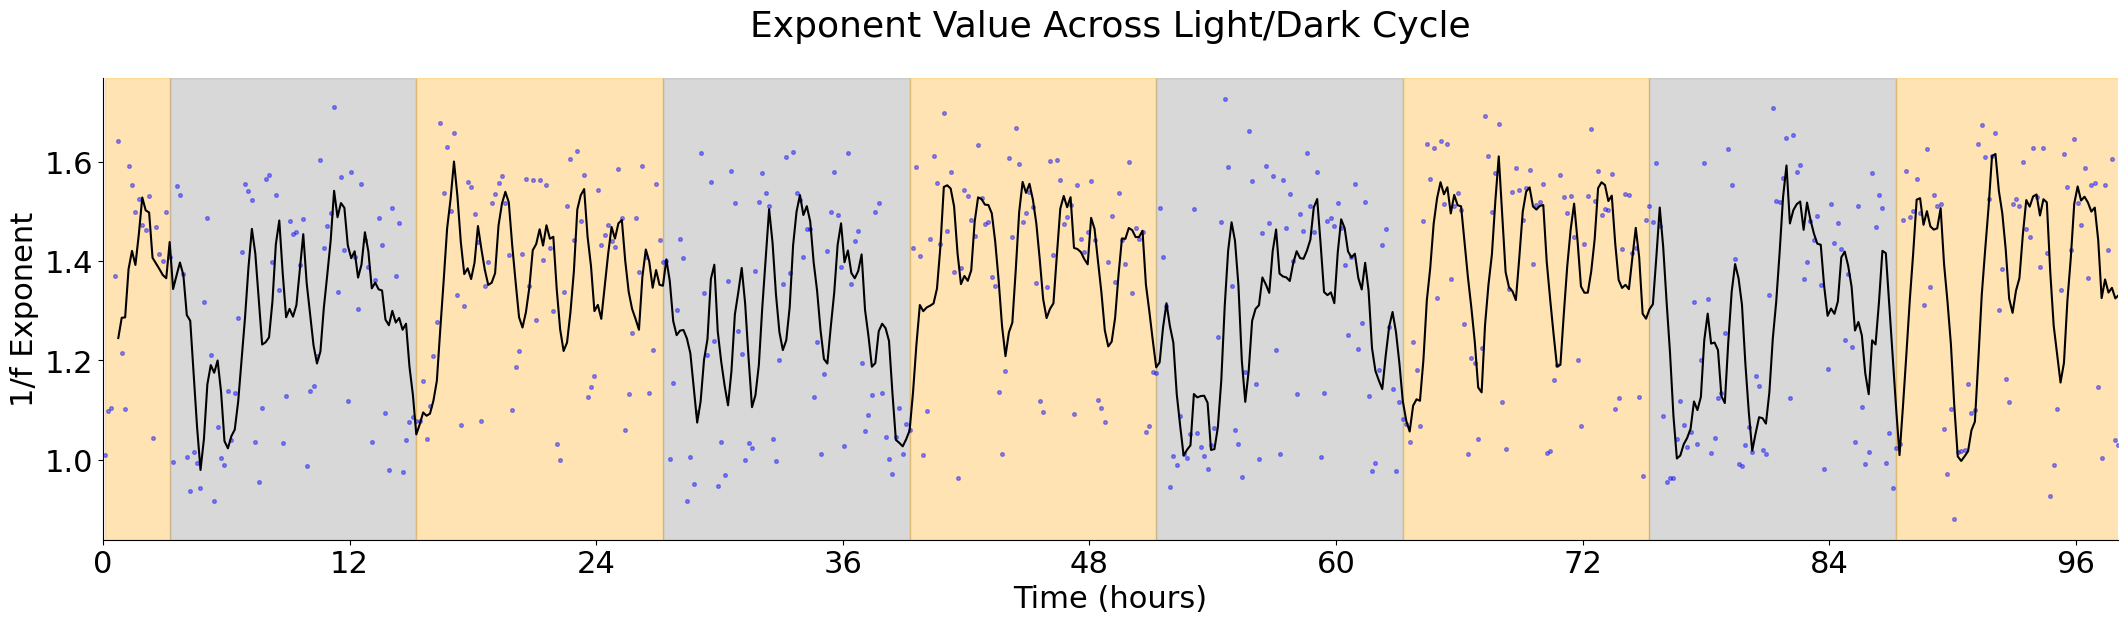

In [298]:
# Plot the average exponent values across ZT - scatter plot every 10 minutes and showing entire recording length of recording

# Group by every 60 rows and calculate the mean for avg_exp
grouped_df = avg_exps_df.groupby(avg_exps_df.index // 60).agg({
    'avg_exp': 'mean',
    'duration_hours': 'mean',
    'ZT': 'first'
})

# Calculate the rolling average
rolling_window_size = 5  # Adjust this value as needed
grouped_df['rolling_avg'] = grouped_df['avg_exp'].rolling(window=rolling_window_size).mean()

# Create the scatter plot
plt.figure(figsize=(26, 6))

# Plot background shading based on ZT column
current_color = 'orange' if grouped_df['ZT'].iloc[0] < 12 else 'grey'
start_duration = grouped_df['duration_hours'].iloc[0]

for i in range(1, len(grouped_df)):
    end_duration = grouped_df['duration_hours'].iloc[i]
    new_color = 'orange' if grouped_df['ZT'].iloc[i] < 12 else 'grey'
    
    if new_color != current_color:
        plt.axvspan(start_duration, end_duration, color=current_color, alpha=0.3)
        start_duration = end_duration
        current_color = new_color

# Add the last span
plt.axvspan(start_duration, grouped_df['duration_hours'].iloc[-1] + (grouped_df['duration_hours'].iloc[1] - grouped_df['duration_hours'].iloc[0]), color=current_color, alpha=0.3)

# Variable for scatter plot marker size
marker_size = 7  # Adjust this value to reduce or increase the size of the scatter plot markers

# Scatter plot of mean exponent values vs. first duration_hours
plt.scatter(grouped_df['duration_hours'], grouped_df['avg_exp'], c='blue', s=marker_size, alpha=0.4)

# Plot the rolling average line
plt.plot(grouped_df['duration_hours'], grouped_df['rolling_avg'], c='black', label='Rolling Average')

# Add labels and title
plt.xlabel('Time (hours)', fontsize=22)
plt.ylabel('1/f Exponent', fontsize=22)
plt.title('Exponent Value Across Light/Dark Cycle', fontsize=26, pad=30)

# Set x-ticks every 12 hours
max_duration = grouped_df['duration_hours'].max()
plt.xticks(np.arange(0, max_duration, 12), fontsize=22)

# Set x-axis limits to cover the entirety of the edges of the plot box
plt.xlim(0, max_duration)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tick_params(axis='y', labelsize=22)

# Show the plot
plt.show()

In [247]:
## Add somno scoring to avg_exps_dfs

# Calculate the number of rows per epoch
rows_per_epoch = int(epoch_duration * fs)

# Add a column to indicate the epoch
somno_scoring['epoch'] = somno_scoring.index // rows_per_epoch

# Downsample the sleepStage column by taking the mode for each epoch
downsampled_sleep_stage = somno_scoring.groupby('epoch').agg({
    "sleepStage": lambda x: x.mode().iloc[0] if not x.mode().empty else None
}).reset_index(drop=True)

# Check if the number of rows are identical
if len(avg_exps_df) != len(downsampled_sleep_stage):
    print("Error: The number of rows in avg_exps_df and downsampled_sleep_stage are not identical.")
else:
    # Add the downsampled sleepStage values as a new column to avg_exps_df
    avg_exps_df['sleepStage'] = downsampled_sleep_stage['sleepStage'].values

KeyboardInterrupt: 

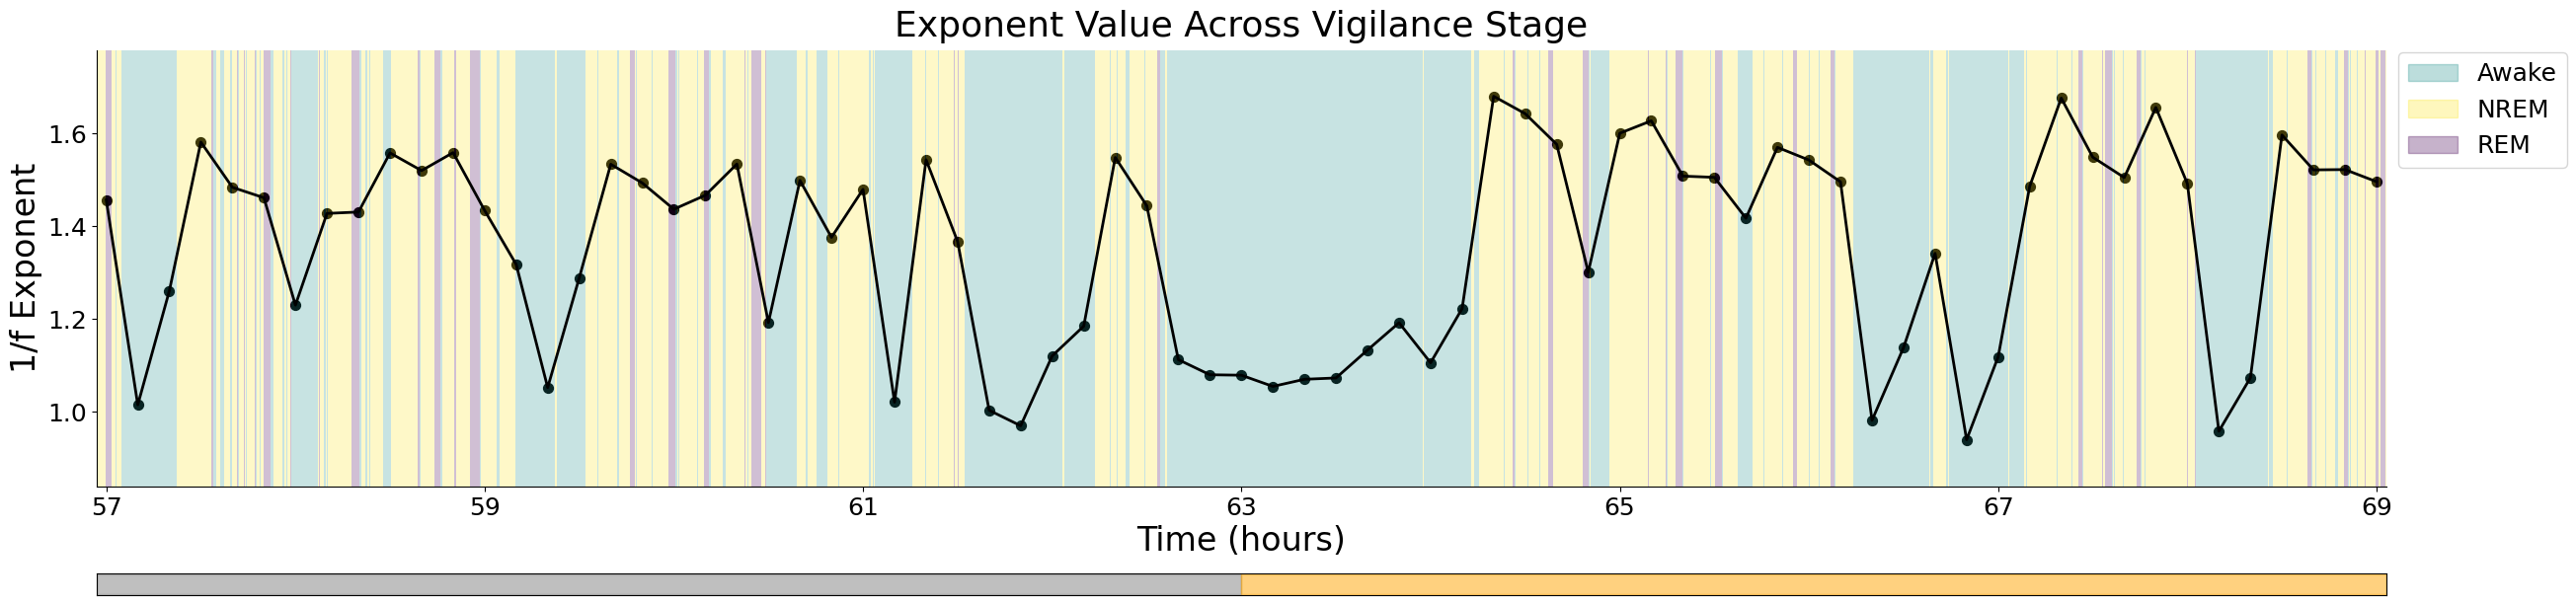

In [349]:
# Filter data within the 57–69 hours range - provide some context for the window size and interval
filtered_df = avg_exps_df[(avg_exps_df['duration_hours'] >= 56.9) & 
                          (avg_exps_df['duration_hours'] <= 69.1)].copy()

# Define constants for window size and interval
half_window = 5 / 60  # 5 minutes in fractional hours
interval = 10 / 60    # 10 minutes in fractional hours

# Create a time range with 10-minute intervals starting at 57 - provide extra for end point
time_points = np.arange(57, 69.1, interval)

# Compute the average for each time window
means = []
for tp in time_points:
    # Define the start and end of the averaging window
    window_start = tp - half_window
    window_end = tp + half_window
    
    # Select data within this window
    window_data = filtered_df[(filtered_df['duration_hours'] >= window_start) & 
                              (filtered_df['duration_hours'] <= window_end)]
    
    # Compute the mean avg_exp for this window
    means.append(window_data['avg_exp'].mean())

# Create a new DataFrame for grouped data
grouped_df = pd.DataFrame({
    'duration_hours': time_points,
    'avg_exp': means
})

# Create figure and axis
#fig, ax = plt.subplots(figsize=(26, 6))
fig, ax = plt.subplots(figsize=(26, 6), constrained_layout=True)

# Plot data points and line
ax.scatter(grouped_df['duration_hours'], grouped_df['avg_exp'], color='black', label='Data Points', marker='o', s=50)
ax.plot(grouped_df['duration_hours'], grouped_df['avg_exp'], color='black', linestyle='-', linewidth=2)

# Sort data by duration_hours
filtered_df = filtered_df.sort_values('duration_hours')

# Get unique stages and colors
unique_stages = filtered_df['sleepStage'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_stages)))

# Manually map colors to stages
stage_color_map = {
    1: colors[1],  # 2nd color
    2: colors[2],  # 3rd color
    3: colors[0]   # 1st color
}

# Modified segment creation with gaps
segments = []
current_stage = filtered_df.iloc[0]['sleepStage']
start_hour = filtered_df.iloc[0]['duration_hours']

for i in range(1, len(filtered_df)):
    if filtered_df.iloc[i]['sleepStage'] != current_stage:
        segments.append({
            'start': start_hour,
            'end': filtered_df.iloc[i]['duration_hours'],  # Subtract gap
            'stage': current_stage
        })
        start_hour = filtered_df.iloc[i]['duration_hours']
        current_stage = filtered_df.iloc[i]['sleepStage']

# Add final segment
segments.append({
    'start': start_hour,
    'end': filtered_df.iloc[-1]['duration_hours'],  # No gap needed for last segment
    'stage': current_stage
})

# Plot segments with modified boundaries
for segment in segments:
    color = stage_color_map[segment['stage']]
    ax.axvspan(segment['start'], segment['end'], facecolor=color, alpha=0.25, antialiased=False, edgecolor='none')

# Create legend patches with new names and sort them in the desired order
legend_patches = [mpatches.Patch(color=stage_color_map[stage], alpha=0.3, label={1: 'Awake', 2: 'NREM', 3: 'REM'}[stage]) 
                  for stage in unique_stages]

# Sort legend patches in the order of Awake, NREM, REM
order = ['Awake', 'NREM', 'REM']
legend_patches = sorted(legend_patches, key=lambda x: order.index(x.get_label()))

# Add legend in top right corner, closer to plot, and increase font size
ax.legend(handles=legend_patches,
          loc='upper right', 
          bbox_to_anchor=(1.08, 1),
          borderaxespad=0.1,
          fontsize=18)

# Labels and title
ax.set_xlabel('Time (hours)', fontsize=24)
ax.set_ylabel('1/f Exponent', fontsize=24)
ax.set_title('Exponent Value Across Vigilance Stage', fontsize=26, pad=10)

# Create inset axis for rectangle bars
inset_ax = ax.inset_axes([0, -0.25, 1, 0.05], transform=ax.transAxes)
inset_ax.axhspan(0, 1, xmin=0, xmax=(63-57)/(69-57), color='grey', alpha=0.5)
inset_ax.axhspan(0, 1, xmin=(63-57)/(69-57), xmax=1, color='orange', alpha=0.5)

# Format axes
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_xlim(57, 69)
ax.set_xlim(56.95, 69.05)
ax.set_ylim(grouped_df['avg_exp'].min() - 0.1, grouped_df['avg_exp'].max() + 0.1)

# Set x-ticks to start at 57 and at every second value until 69
ax.set_xticks(range(57, 70, 2))
ax.tick_params(axis='both', which='major', labelsize=18)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.tight_layout()
plt.show()


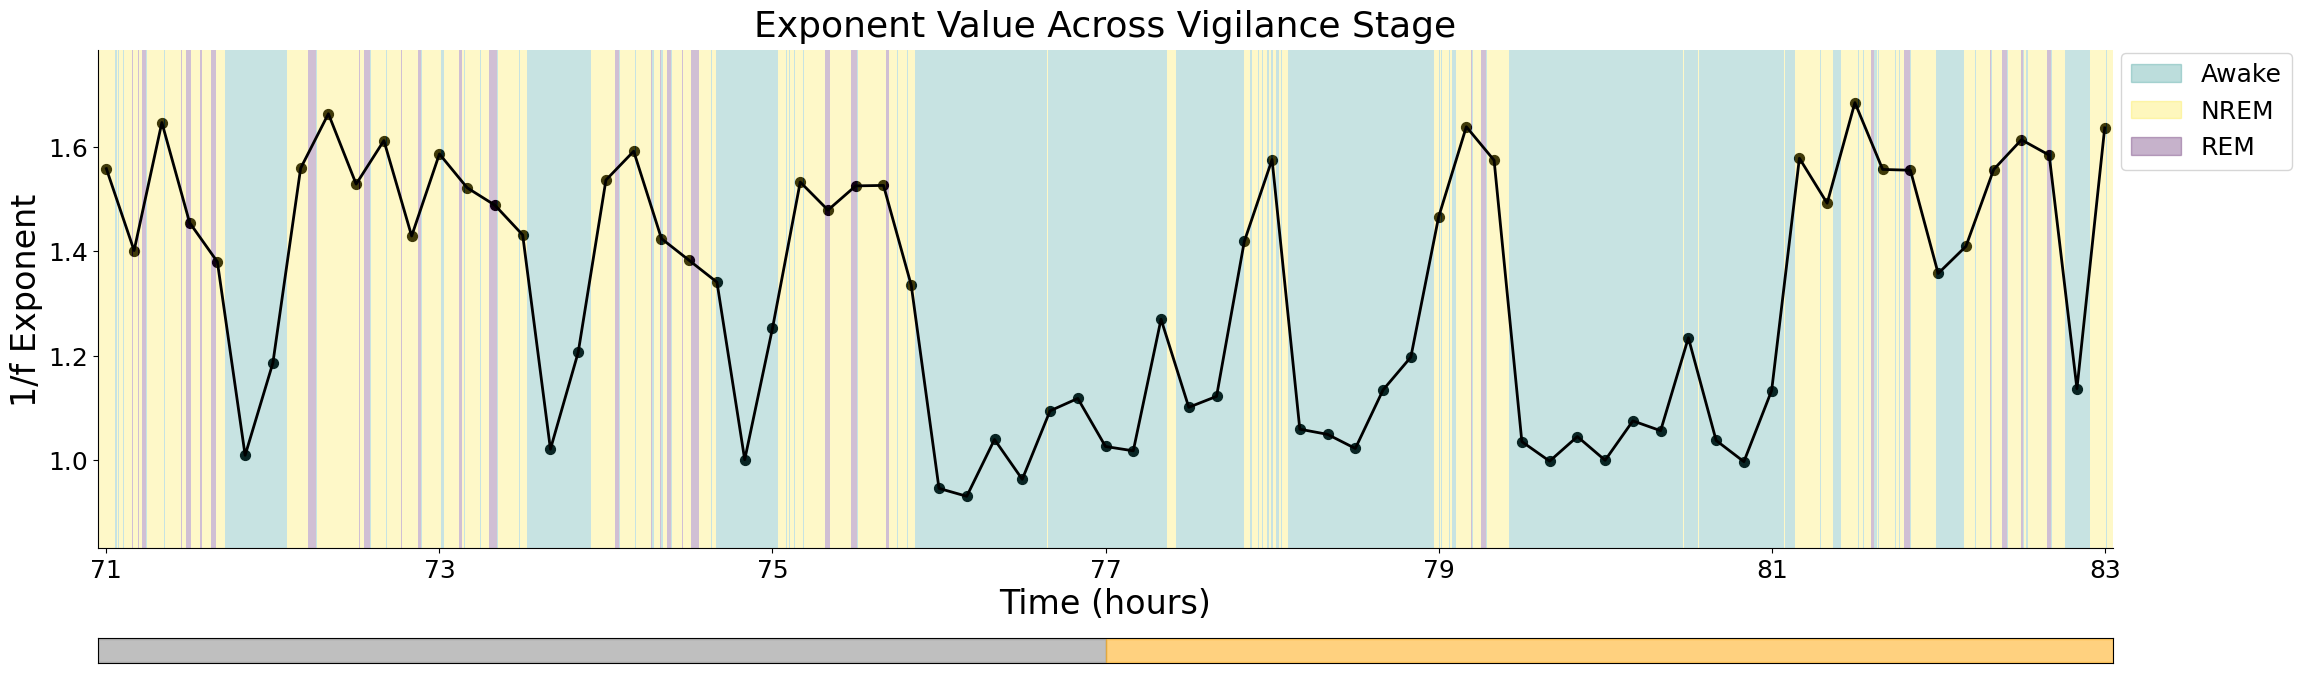

In [321]:
# Filter data within the 57–69 hours range - provide some context for the window size and interval
filtered_df = avg_exps_df[(avg_exps_df['duration_hours'] >= 70.9) & 
                          (avg_exps_df['duration_hours'] <= 83.1)].copy()

# Define constants for window size and interval
half_window = 5 / 60  # 5 minutes in fractional hours
interval = 10 / 60    # 10 minutes in fractional hours

# Create a time range with 10-minute intervals starting at 57 - provide extra for end point
time_points = np.arange(71, 83.1, interval)

# Compute the average for each time window
means = []
for tp in time_points:
    # Define the start and end of the averaging window
    window_start = tp - half_window
    window_end = tp + half_window
    
    # Select data within this window
    window_data = filtered_df[(filtered_df['duration_hours'] >= window_start) & 
                              (filtered_df['duration_hours'] <= window_end)]
    
    # Compute the mean avg_exp for this window
    means.append(window_data['avg_exp'].mean())

# Create a new DataFrame for grouped data
grouped_df = pd.DataFrame({
    'duration_hours': time_points,
    'avg_exp': means
})

# Create figure and axis
fig, ax = plt.subplots(figsize=(26, 6))
fig.subplots_adjust(bottom=0.05)

# Plot data points and line
ax.scatter(grouped_df['duration_hours'], grouped_df['avg_exp'], color='black', label='Data Points', marker='o', s=50)
ax.plot(grouped_df['duration_hours'], grouped_df['avg_exp'], color='black', linestyle='-', linewidth=2)

# Sort data by duration_hours
filtered_df = filtered_df.sort_values('duration_hours')

# Get unique stages and colors
unique_stages = filtered_df['sleepStage'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_stages)))

# Manually map colors to stages
stage_color_map = {
    1: colors[1],  # 2nd color
    2: colors[2],  # 3rd color
    3: colors[0]   # 1st color
}

# Modified segment creation with gaps
segments = []
current_stage = filtered_df.iloc[0]['sleepStage']
start_hour = filtered_df.iloc[0]['duration_hours']

for i in range(1, len(filtered_df)):
    if filtered_df.iloc[i]['sleepStage'] != current_stage:
        segments.append({
            'start': start_hour,
            'end': filtered_df.iloc[i]['duration_hours'],  # Subtract gap
            'stage': current_stage
        })
        start_hour = filtered_df.iloc[i]['duration_hours']
        current_stage = filtered_df.iloc[i]['sleepStage']

# Add final segment
segments.append({
    'start': start_hour,
    'end': filtered_df.iloc[-1]['duration_hours'],  # No gap needed for last segment
    'stage': current_stage
})

# Plot segments with modified boundaries
for segment in segments:
    color = stage_color_map[segment['stage']]
    ax.axvspan(segment['start'], segment['end'], facecolor=color, alpha=0.25, antialiased=False, edgecolor='none')

# Create legend patches with new names and sort them in the desired order
legend_patches = [mpatches.Patch(color=stage_color_map[stage], alpha=0.3, label={1: 'Awake', 2: 'NREM', 3: 'REM'}[stage]) 
                  for stage in unique_stages]

# Sort legend patches in the order of Awake, NREM, REM
order = ['Awake', 'NREM', 'REM']
legend_patches = sorted(legend_patches, key=lambda x: order.index(x.get_label()))

# Add legend in top right corner, closer to plot, and increase font size
ax.legend(handles=legend_patches,
          loc='upper right', 
          bbox_to_anchor=(1.09, 1),
          borderaxespad=0.1,
          fontsize=18)

# Labels and title
ax.set_xlabel('Time (hours)', fontsize=24)
ax.set_ylabel('1/f Exponent', fontsize=24)
ax.set_title('Exponent Value Across Vigilance Stage', fontsize=26, pad=10)

# Create inset axis for rectangle bars
inset_ax = ax.inset_axes([0, -0.23, 1, 0.05], transform=ax.transAxes)
inset_ax.axhspan(0, 1, xmin=0, xmax=(77-71)/(83-71), color='grey', alpha=0.5)
inset_ax.axhspan(0, 1, xmin=(77-71)/(83-71), xmax=1, color='orange', alpha=0.5)

# Format axes
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_xlim(71, 83)
ax.set_xlim(70.95, 83.05)
ax.set_ylim(grouped_df['avg_exp'].min() - 0.1, grouped_df['avg_exp'].max() + 0.1)

# Set x-ticks to start at 57 and at every second value until 69
ax.set_xticks(range(71, 84, 2))
ax.tick_params(axis='both', which='major', labelsize=18)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()
